### This notebook demos basic Profiling workflows in Great Expectations

Please note that Profiling is still an experimental feature in GE.

In [1]:
import logging
import glob
import random
import json

import pandas as pd
import pylab as plt
from pylab import rcParams

import great_expectations as ge
from great_expectations.profile.multidataset_profiler import MultiDatasetProfiler
from great_expectations.dataset import PandasDataset
from great_expectations.jupyter_ux import (
    setup_notebook_logging,
    display_column_expectations_as_section,
    display_profiled_column_evrs_as_section,
    display_column_evrs_as_section,
    display_evrs_as_section,
    display_expectation_validation_metric_plot,
)

2020-04-07T11:15:19-0700 - INFO - Great Expectations logging enabled at 20 level by JupyterUX module.


In [2]:
#Turn off logging, because we're in a notebook
setup_notebook_logging(log_level=logging.WARNING)

# Make plots wide and pretty
rcParams['figure.figsize'] = 14, 4

In [3]:
# Load a sabermetric csv from 538
# Original source: 538_data/data/mlb-allstar-teams/allstar_player_talent.csv

df = ge.read_csv("data/foul-balls.csv")
df.shape

(906, 7)

In [4]:
# Take a look at the data.

df.head()

,matchup,game_date,type_of_hit,exit_velocity,predicted_zone,camera_zone,used_zone
0,Seattle Mariners VS Minnesota Twins,2019-05-18,Ground,NaN,1,1.0,1
1,Seattle Mariners VS Minnesota Twins,2019-05-18,Fly,NaN,4,NaN,4
2,Seattle Mariners VS Minnesota Twins,2019-05-18,Fly,56.9,4,NaN,4
3,Seattle Mariners VS Minnesota Twins,2019-05-18,Fly,78.8,1,1.0,1
4,Seattle Mariners VS Minnesota Twins,2019-05-18,Fly,NaN,2,NaN,2


In [5]:
# Let's build an expectation by hand

df.expect_column_values_to_not_be_null("exit_velocity", mostly=.6)

{
  "exception_info": null,
  "success": true,
  "meta": {},
  "result": {
    "element_count": 906,
    "unexpected_count": 326,
    "unexpected_percent": 35.98233995584989,
    "partial_unexpected_list": []
  }
}

In [6]:
# Split up the dataframe into 20 batches

def split_dataframe_by_rows(df, k=5):
    dataset_list = []
    row_count = df.shape[0]
    for i in range(k):
        start_row, end_row = i*int(row_count/k), (i+1)*int(row_count/k)
        dataset_list.append(df[start_row:end_row])
        
    return dataset_list

dataset_list = split_dataframe_by_rows(df, 20)

In [7]:
# Configure a profiler and a dummy "store" to retain result metadata

validation_result_list = []
my_profiler = MultiDatasetProfiler(
    validation_result_store=validation_result_list,
#     column_whitelist=["type_of_hit"]
)

In [8]:
# Profile half of the batches. Hold the rest out for later testing

profiled_expectation_suite = my_profiler.profile(dataset_list[10:])

In [9]:
# Get validation results from one of the batches used for profiling

first_validation_results = validation_result_list[0]

In [10]:
# Pick a column

# random_column = random.choice(df.columns)
random_column = "type_of_hit"

In [11]:
# Render the results, EDA-style

display_profiled_column_evrs_as_section(
    first_validation_results,
    random_column,
)

Distinct (n) expect_column_unique_value_count_to_be_between,4
Distinct (%) expect_column_proportion_of_unique_values_to_be_between,8.9%
Missing (n) expect_column_values_to_not_be_null,0
Missing (%) expect_column_values_to_not_be_null,0.0%


In [12]:
# Render the profiled expectations that support the EDA

display_column_expectations_as_section(
    profiled_expectation_suite,
    random_column,
)

In [13]:
# Fetch a fresh batch and validate it

new_batch = PandasDataset(
    dataset_list[1],
    expectation_suite=profiled_expectation_suite
)

In [14]:
# Display validation results for the chosen column

new_validation_results = new_batch.validate(result_format="SUMMARY")

display_column_evrs_as_section(
    new_validation_results,
    random_column,
    include_styling=True
)

Status,Expectation,Observed Value
,must have between 3 and 5 unique values.,5
,fraction of unique values must be between 0.06666666666666667 and 0.1111111111111111.,≈0.1111111111
,values must never be null.,100% not null
,values must belong to this set: Fly Batter hits self Line Pop Up Ground.,0% unexpected
,values must not match this regular expression: ^\s+|\s+$.,0% unexpected


In [15]:
# Drop an expectation that we don't care about

new_batch.remove_expectation(
    expectation_type="expect_column_proportion_of_unique_values_to_be_between",
    column=random_column
)

In [16]:
# Validate expectations again. This time, show only the failing expectations.

new_validation_results = new_batch.validate(result_format="SUMMARY")

display_evrs_as_section(
    new_validation_results,
    only_include_failed_evrs=True,
    include_styling=True
)

In [17]:
# Edit two expectations to make them more inclusive

new_batch.expect_column_values_to_be_in_set("used_zone", [1,2,3,4,5,6,7])
new_batch.expect_column_values_to_be_in_set("predicted_zone", [1,2,3,4,5,6,7])

{
  "exception_info": null,
  "success": true,
  "meta": {},
  "result": {
    "element_count": 45,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  }
}

In [18]:
# Drop one expectation that we don't want

new_batch.remove_expectation(expectation_type="expect_column_values_to_be_in_set", column="exit_velocity")

In [19]:
# Add a value to another expectation that was too limiting

prev_expectation = new_batch.find_expectations(
    expectation_type="expect_column_values_to_be_in_set",
    column="game_date",
)[0]
new_batch.expect_column_values_to_be_in_set(
    "game_date",
    value_set=prev_expectation["kwargs"]["value_set"]+["2019-05-18"]
)

{
  "exception_info": null,
  "success": true,
  "meta": {},
  "result": {
    "element_count": 45,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  }
}

In [20]:
#...and again

prev_expectation = new_batch.find_expectations(
    expectation_type="expect_column_values_to_be_in_set",
    column="matchup",
)[0]
new_batch.expect_column_values_to_be_in_set(
    "matchup",
    value_set=prev_expectation["kwargs"]["value_set"]+["Seattle Mariners VS Minnesota Twins"]
)

{
  "exception_info": null,
  "success": true,
  "meta": {},
  "result": {
    "element_count": 45,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  }
}

In [21]:
# Validate the rest of the datasets
full_validation_result_list = [ge.validate(dataset, profiled_expectation_suite) for dataset in dataset_list]

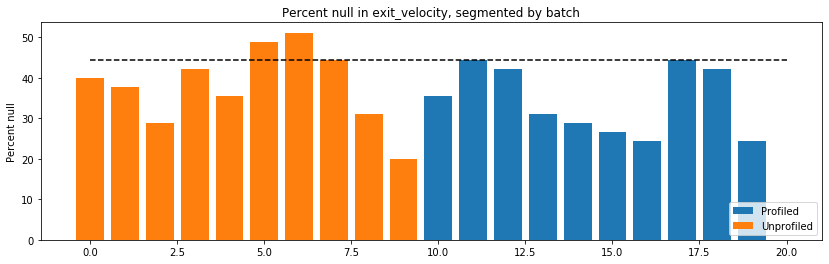

In [22]:
# Generate a graph so that we can figure out what's going on with another one of the broken Expectations

display_expectation_validation_metric_plot(
    full_validation_result_list,
    expectation_type="expect_column_values_to_not_be_null",
    column="exit_velocity",
)

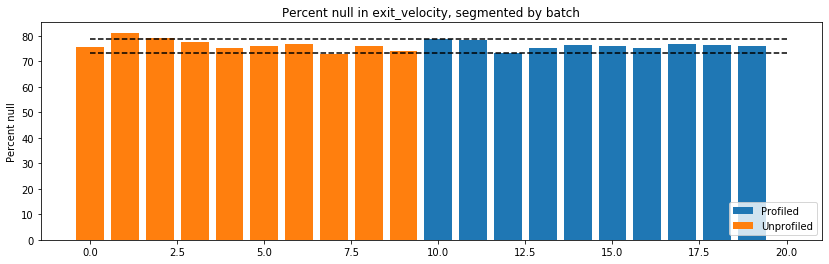

In [23]:
# Generate a graph so that we can figure out what's going on with one of the broken Expectations

display_expectation_validation_metric_plot(
    full_validation_result_list,
    expectation_type="expect_column_mean_to_be_between",
    column="exit_velocity",
)